# Lab 1 - Quantization and pruning experiments
- Lab & tutorials written by Aaron Zhao and Pedro Gimenes
- implementation task answer written by [Gwendal Casta](mailto:gwendal.casta24@imperial.ac.uk)

## Fixed-point quantization
We explore how different fixed-point widths affect the accuracy of IMDb classification using Post-Training Quantization (PTQ) and Quantization-Aware Training (QAT).
### Import dependencies

In [1]:
import os
import matplotlib.pyplot as plt
from transformers import AutoModelForSequenceClassification
from chop import MaseGraph
import chop.passes as passes
from chop.tools import get_tokenized_dataset, get_trainer
from pathlib import Path

/home/infres/casta-22/miniconda3/envs/mase/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load fine-tuned model
The model is loaded into a MaseGraph instance.

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

path = f"{Path.home()}/ADLS/tutorial_2_lora"
print(f"Loading fine-tuned model from: {path}")

mg = MaseGraph.from_checkpoint(path)

Loading fine-tuned model from: /home/infres/casta-22/ADLS/tutorial_2_lora


WARNING  Node finfo not found in loaded metadata.
WARNING  Node getattr_2 not found in loaded metadata.


### Prepare dataset and trainer

In [4]:
dataset_name = "imdb"
tokenizer_checkpoint = "bert-base-uncased"

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)

# Evaluate baseline accuracy (before quantization)
eval_results = trainer.evaluate()
print(f"Baseline accuracy: {eval_results['eval_accuracy']:.4f}")

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


Baseline accuracy: 0.8369


## Defining fixed-point widths
We define the range of fixed-point widths that will be tested, starting from 4 bits and increasing in steps of 2 until 32 bits. 

In [5]:
widths = list(range(4, 33, 2))
ptq_accuracies = []
qat_accuracies = []

In [6]:
for width in widths:
    print(f"Testing fixed-point width: {width} bits")

    # Define quantization configuration
    quantization_config = {
        "by": "type",
        "default": {"config": {"name": None}},
        "linear": {
            "config": {
                "name": "integer",
                "data_in_width": width,
                "data_in_frac_width": width // 2,
                "weight_width": width,
                "weight_frac_width": width // 2,
                "bias_width": width,
                "bias_frac_width": width // 2,
            }
        },
    }

    # Apply PTQ
    mg, _ = passes.quantize_transform_pass(mg, pass_args=quantization_config)

    # Evaluate accuracy after PTQ
    trainer = get_trainer(
        model=mg.model,
        tokenized_dataset=dataset,
        tokenizer=tokenizer,
        evaluate_metric="accuracy",
    )
    eval_results = trainer.evaluate()
    ptq_accuracies.append(eval_results["eval_accuracy"])
    print(f"PTQ Accuracy: {eval_results['eval_accuracy']:.4f}")

    # Apply QAT by training the model
    trainer.train()
    eval_results_qat = trainer.evaluate()
    qat_accuracies.append(eval_results_qat["eval_accuracy"])
    print(f"QAT Accuracy: {eval_results_qat['eval_accuracy']:.4f}\n")

Testing fixed-point width: 4 bits


PTQ Accuracy: 0.5000


Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693100
2000,0.693100
2500,0.693100
3000,0.693100


QAT Accuracy: 0.5000

Testing fixed-point width: 6 bits


PTQ Accuracy: 0.6476


Step,Training Loss
500,0.486900
1000,0.420400
1500,0.422900
2000,0.409400
2500,0.403800
3000,0.411200


QAT Accuracy: 0.8328

Testing fixed-point width: 8 bits


PTQ Accuracy: 0.7744


Step,Training Loss
500,0.402600
1000,0.386200
1500,0.401500
2000,0.386500
2500,0.387300
3000,0.397000


QAT Accuracy: 0.8414

Testing fixed-point width: 10 bits


PTQ Accuracy: 0.8326


Step,Training Loss
500,0.388700
1000,0.380000
1500,0.399900
2000,0.377300
2500,0.375100
3000,0.395600


QAT Accuracy: 0.8440

Testing fixed-point width: 12 bits


PTQ Accuracy: 0.8369


Step,Training Loss
500,0.387800
1000,0.377800
1500,0.394900
2000,0.375900
2500,0.373200
3000,0.392600


QAT Accuracy: 0.8430

Testing fixed-point width: 14 bits


PTQ Accuracy: 0.8382


Step,Training Loss
500,0.386900
1000,0.377700
1500,0.395000
2000,0.373500
2500,0.375000
3000,0.392200


QAT Accuracy: 0.8426

Testing fixed-point width: 16 bits


PTQ Accuracy: 0.8372


Step,Training Loss
500,0.385900
1000,0.377100
1500,0.394600
2000,0.373200
2500,0.374300
3000,0.393000


QAT Accuracy: 0.8437

Testing fixed-point width: 18 bits


PTQ Accuracy: 0.8373


Step,Training Loss
500,0.387400
1000,0.376700
1500,0.394100
2000,0.372600
2500,0.374400
3000,0.393100


QAT Accuracy: 0.8435

Testing fixed-point width: 20 bits


PTQ Accuracy: 0.8374


Step,Training Loss
500,0.386900
1000,0.376700
1500,0.394600
2000,0.373000
2500,0.374200
3000,0.392800


QAT Accuracy: 0.8432

Testing fixed-point width: 22 bits


PTQ Accuracy: 0.8374


Step,Training Loss
500,0.386700
1000,0.376500
1500,0.394500
2000,0.372800
2500,0.374100
3000,0.392900


QAT Accuracy: 0.8433

Testing fixed-point width: 24 bits


PTQ Accuracy: 0.8371


Step,Training Loss
500,0.386500
1000,0.376300
1500,0.394500
2000,0.372800
2500,0.374200
3000,0.392900


QAT Accuracy: 0.8434

Testing fixed-point width: 26 bits


PTQ Accuracy: 0.8372


Step,Training Loss
500,0.386400
1000,0.376300
1500,0.394500
2000,0.372700
2500,0.374100
3000,0.392900


QAT Accuracy: 0.8434

Testing fixed-point width: 28 bits


PTQ Accuracy: 0.8372


Step,Training Loss
500,0.386300
1000,0.376300
1500,0.394400
2000,0.372700
2500,0.374100
3000,0.392900


QAT Accuracy: 0.8432

Testing fixed-point width: 30 bits


PTQ Accuracy: 0.8371


Step,Training Loss
500,0.386200
1000,0.376200
1500,0.394300
2000,0.372700
2500,0.374100
3000,0.392900


QAT Accuracy: 0.8433

Testing fixed-point width: 32 bits


PTQ Accuracy: 0.8372


Step,Training Loss
500,0.386100
1000,0.376100
1500,0.394300
2000,0.372600
2500,0.374100
3000,0.392900


QAT Accuracy: 0.8433



### Plot accuracy vs fixed-point width
Plot comparing accuracy across different fixed-point widths. Two curves are displayed:
- PTQ accuracy (direct quantization without training).
- QAT accuracy (quantization followed by additional training).

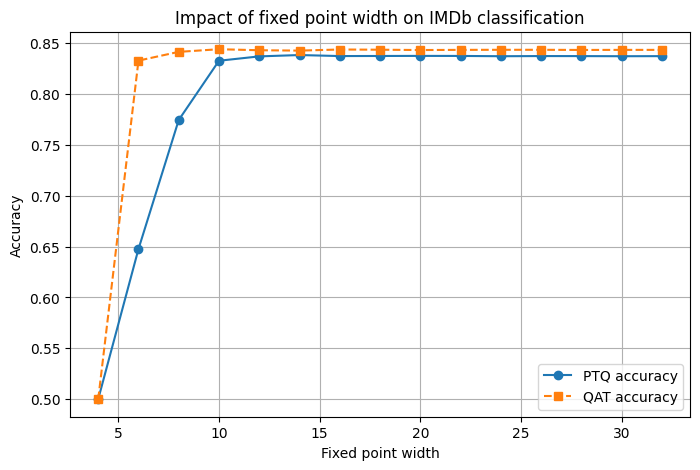

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(widths, ptq_accuracies, marker="o", linestyle="-", label="PTQ accuracy")
plt.plot(widths, qat_accuracies, marker="s", linestyle="--", label="QAT accuracy")
plt.xlabel("Fixed point width")
plt.ylabel("Accuracy")
plt.title("Impact of fixed point width on IMDb classification")
plt.legend()
plt.grid()
plt.show()

## Pruning experiments

### Load the best quantized model

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

best_model_checkpoint = f"{Path.home()}/ADLS/tutorial_3_qat"
print(f"Loading best quantized model from: {best_model_checkpoint}")

mg = MaseGraph.from_checkpoint(best_model_checkpoint)

Loading best quantized model from: /home/infres/casta-22/ADLS/tutorial_3_qat


### Prepare dataset and trainer

In [4]:
dataset_name = "imdb"
tokenizer_checkpoint = "bert-base-uncased"

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)

eval_results = trainer.evaluate()
print(f"Baseline accuracy (quantized model): {eval_results['eval_accuracy']:.4f}")

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.


Baseline accuracy (quantized model): 0.8401



### Define sparsity levels
We define sparsity levels from 20% to 80%

In [ ]:
sparsity_levels = [round(x, 1) for x in [i * 0.1 for i in range(1, 10)]]

# Lists to store accuracy results
random_accuracies = []
l1_norm_accuracies = []

In [6]:
sparsity_levels

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

### Apply random and L1-norm pruning
This loop iterates over different sparsity levels and applies both Random and L1-Norm pruning. Each pruned model is evaluated for accuracy.

In [ ]:
for sparsity in sparsity_levels:
    print(f"Applying pruning with {sparsity*100:.0f}% sparsity")

    # Random pruning configuration
    random_pruning_config = {
        "weight": {"sparsity": sparsity, "method": "random", "scope": "local"},
        "activation": {"sparsity": sparsity, "method": "random", "scope": "local"},
    }

    # Apply random pruning
    mg_random, _ = passes.prune_transform_pass(mg, pass_args=random_pruning_config)
    
    # Evaluate accuracy after random pruning
    trainer.model = mg_random.model.to('cuda')
    eval_results = trainer.evaluate()
    random_accuracies.append(eval_results["eval_accuracy"])
    print(f"Random pruning accuracy: {eval_results['eval_accuracy']:.4f}")

    # L1-norm pruning configuration
    l1_pruning_config = {
        "weight": {"sparsity": sparsity, "method": "l1-norm", "scope": "local"},
        "activation": {"sparsity": sparsity, "method": "l1-norm", "scope": "local"},
    }

    # Apply l1-norm pruning
    mg_l1, _ = passes.prune_transform_pass(mg, pass_args=l1_pruning_config)
    
    # Evaluate accuracy after L1-Norm Pruning
    trainer.model = mg_l1.model.to('cuda')
    eval_results_l1 = trainer.evaluate()
    l1_norm_accuracies.append(eval_results_l1["eval_accuracy"])
    print(f"L1-Norm pruning accuracy: {eval_results_l1['eval_accuracy']:.4f}\n")

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Applying pruning with 10% sparsity


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Random pruning accuracy: 0.7640


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


L1-Norm pruning accuracy: 0.7631

Applying pruning with 20% sparsity


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Random pruning accuracy: 0.5134


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


L1-Norm pruning accuracy: 0.5133

Applying pruning with 30% sparsity


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Random pruning accuracy: 0.4998


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


L1-Norm pruning accuracy: 0.5028

Applying pruning with 40% sparsity


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Random pruning accuracy: 0.5023


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


L1-Norm pruning accuracy: 0.4985

Applying pruning with 50% sparsity


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Random pruning accuracy: 0.5030


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


L1-Norm pruning accuracy: 0.5040

Applying pruning with 60% sparsity


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Random pruning accuracy: 0.4997


### Plot accuracy vs sparsity
We visualize the accuracy drop as sparsity increases. The two curves compare:
- Random pruning.
- L1-Norm pruning.

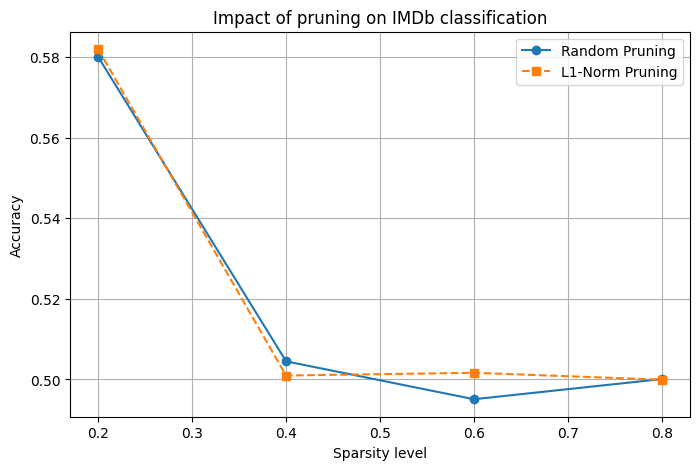

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(sparsity_levels, random_accuracies, marker="o", linestyle="-", label="Random pruning")
plt.plot(sparsity_levels, l1_norm_accuracies, marker="s", linestyle="--", label="L1-Norm pruning")
plt.xlabel("Sparsity level")
plt.ylabel("Accuracy")
plt.title("Impact of pruning")
plt.legend()
plt.grid()
plt.show()